# **Poliadenila√ß√£o Alternativa de scRNA-Seq**

A poliadenila√ß√£o alternativa (APA) √© um processo biol√≥gico que ocorre durante o amadurecimento do RNA mensageiro (mRNA), no qual diferentes sinais de finaliza√ß√£o (poliadenila√ß√£o) s√£o usados em um mesmo gene. Isso significa que uma √∫nica sequ√™ncia de DNA pode gerar m√∫ltiplas vers√µes de mRNA com diferentes comprimentos na extremidade 3‚Äô. Essas varia√ß√µes podem afetar a estabilidade do RNA, onde ele ser√° localizado na c√©lula e como ser√° traduzido em prote√≠na. Como resultado, a APA tem um papel importante na regula√ß√£o da express√£o g√™nica e pode estar associada a processos como diferencia√ß√£o celular e doen√ßas como o c√¢ncer.

O [SCAPE-APA](https://github.com/chengl7-lab/scape) (Single Cell Analysis of Polyadenylation Events) √© um pacote computacional desenvolvido para identificar e quantificar eventos de poliadenila√ß√£o alternativa em dados de scRNA-seq. Ele permite estudar como diferentes c√©lulas usam diferentes s√≠tios de poliadenila√ß√£o em seus genes, revelando camadas adicionais de regula√ß√£o que n√£o s√£o detectadas apenas pela an√°lise de express√£o g√™nica cl√°ssica.

Neste notebook, vamos utilizar o SCAPE-APA dentro do ambiente Google Colab para estimar eventos de poliadenila√ß√£o alternativa em dados de scRNA-seq. O objetivo √© oferecer uma introdu√ß√£o pr√°tica e intuitiva a esse tipo de an√°lise, mostrando como a APA contribui para a diversidade regulat√≥ria entre c√©lulas individuais.

In [ ]:
# Instalamos o python3-conda
# (!) sinaliza que √© um comando para o terminal Linux

!apt-get install -y python3-conda

### Conda

Conda √© um gerenciador de pacotes e ambientes usado principalmente em ci√™ncia de dados e bioinform√°tica. Ele facilita a instala√ß√£o de softwares e bibliotecas, mesmo aquelas com depend√™ncias complexas.

Um ambiente virtual Conda √© um espa√ßo isolado onde voc√™ pode instalar vers√µes espec√≠ficas de pacotes sem interferir em outras instala√ß√µes no seu sistema. Isso evita conflitos e garante reprodutibilidade das an√°lises.

In [ ]:
# Instalando o pacote condalab, permitindo que voc√™ use o Conda no Google Colab, al√©m de seus pacotes e recursos.

!pip install -q condacolab
import condacolab
condacolab.install()

‚ú®üç∞‚ú® Everything looks OK!


In [ ]:
# Instala√ß√£o de pacotes e ferramentas num√©ricas para visualiza√ß√£o e gerenciamento de dados no ambiente Conda.

# Cria o ambieente com o nome scape_env com vers√£o do python 3.11
!conda create -y -n scape_env python=3.11

#instala os pacotes necess√°rios
!conda run -n scape_env conda install -y anaconda::numpy anaconda::scipy anaconda::pandas anaconda::matplotlib
!conda run -n scape_env conda install -y anaconda::click anaconda::tomli-w anaconda::requests
!conda run -n scape_env conda install -y conda-forge::psutil conda-forge::tomli-w
!conda run -n scape_env conda install -y bioconda::bedtools bioconda::pybedtools bioconda::pysam bioconda::gffutils
!conda run -n scape_env pip install taichi
!conda run -n scape_env pip install scape-apa

In [ ]:
# Verificando a instala√ß√£o do SCAPE-APA.

!conda run -n scape_env bash -c "unset MPLBACKEND && export MPLBACKEND=Agg && scape --help"

### GitHub

GitHub √© uma plataforma online onde desenvolvedores armazenam, compartilham e colaboram em projetos de c√≥digo, usando o sistema de controle de vers√£o Git.

O comando git clone √© usado para copiar um reposit√≥rio inteiro do GitHub (ou de outro servidor Git) para o seu local. Ele baixa todos os arquivos, hist√≥rico de vers√µes e a estrutura do projeto, permitindo que voc√™ trabalhe localmente. Vamos fazer isso como o SCAPE-APA

In [ ]:
# Obtendo os arquivos do GitHub do reposit√≥rio.
!git clone https://github.com/chengl7-lab/scape.git
# se movendo para o diret√≥rio de tutorial dentro do scape
%cd scape/tutorial

In [ ]:
# Lista de arquivos dentro da pasta "exemplo de brinquedo".

!ls -lh /content/scape/examples/toy-example/

In [ ]:
# Alterar diret√≥rio.

%cd /content/scape/examples/toy-example/

In [ ]:
# Baixar arquivo de anota√ß√£o "Mus_musculus.GRCm39.113.chr.gff3"
#wget √© para fazer o download
# -O para definir onde o arquivo vai e qual nome
!wget -O /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3 https://ftp.ensembl.org/pub/release-113/gff3/mus_musculus/Mus_musculus.GRCm39.113.chr.gff3.gz

In [ ]:
# Verifica√ß√£o de conte√∫do interno.
# head serve apra verificar o topo do arquivo
# -n 20 define que vou ver as primeiras 20 linhas do arquivo
!head -n 20 /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3

In [ ]:
#verificar o tamanho do arquivo

!wc -l /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3

# **Anota√ß√µes de regi√µes UTR**

As UTRs s√£o regi√µes n√£o traduzidas do RNA mensageiro, localizadas nas extremidades 5‚Äô e 3‚Äô do gene. A poliadenila√ß√£o alternativa (APA) geralmente ocorre na extremidade 3‚Äô, dentro da 3‚ÄôUTR. Isso significa que definir corretamente onde est√£o essas regi√µes √© essencial para detectar com precis√£o os diferentes eventos de APA que podem ocorrer em um gene.

O comando `gen_utr_annotation` faz parte do fluxo de an√°lise do SCAPE-APA, e seu principal objetivo √© gerar anota√ß√µes de regi√µes UTR (Untranslated Regions) a partir de um arquivo no formato .gff3, que cont√©m as anota√ß√µes gen√¥micas de uma esp√©cie.

* O que o comando faz na pr√°tica?
1. Ele l√™ o arquivo .gff3, que cont√©m informa√ß√µes sobre a estrutura dos genes.

2. Identifica e extrai as regi√µes 3‚ÄôUTR de cada transcrito com base nessas anota√ß√µes.

3. Gera um arquivo de sa√≠da com essas regi√µes, que ser√° usado pelo SCAPE-APA para detectar os locais onde diferentes sinais de poliadenila√ß√£o aparecem.

In [ ]:
# Chamar SCAPE no ambiente Conda.
# Usar "unset MPLBACKEND" para remover as configura√ß√µes iniciais do Google Colab e 
# "MPLBACKENG=Agg" para renderizar gr√°ficos.

# scape gen_utr_annotation = Chamar SCAPE com o comando "gen_utr_annotation".
# --gff_file = arquivo ".gff3".
# --output_dir = Caminho de sa√≠da do arquivo gerado.
# --res_file_name = Nome do arquivo gerado, resultando no formato ".csv".

!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape gen_utr_annotation \
--gff_file /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3 \
--output_dir /content/scape/examples/toy-example/ \
--res_file_name example_annotation"

Precisamos fazer adapta√ß√µes para o Google Colab, pois ele n√£o suporta a execu√ß√£o direta de scripts Python com o comando `scape` como em um terminal normal.

Para executar o SCAPE-APA no Google Colab, voc√™ deve usar o comando `conda run -n scape_env` para garantir que o ambiente Conda correto seja ativado antes de executar o comando `scape`.

Voc√™ n√£o precisa disso caso execute o SCAPE-APA localmente em seu terminal, pois o ambiente Conda j√° estar√° ativo.
ficaria como:

`scape gen_utr_annotation --gff_file /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.chr.gff3 --output_dir /content/scape/examples/toy-example/ --res_file_name example_annotation`

# **Preparar os dados de scRNA-seq**

O comando `prepare_input` √© uma etapa essencial do pipeline SCAPE-APA e tem como objetivo preparar os dados de scRNA-seq para a detec√ß√£o de eventos de APA.

Ao focar apenas nos reads localizados nas regi√µes UTR, esse passo reduz o ru√≠do e concentra a an√°lise nas √°reas onde ocorrem os eventos de APA. Isso melhora a precis√£o e efici√™ncia da detec√ß√£o, permitindo uma estimativa mais confi√°vel dos diferentes locais de poliadenila√ß√£o nas c√©lulas individuais.

* O que ele faz:
1. Processa o arquivo .bam, que cont√©m os alinhamentos dos reads de RNA-seq de c√©lula √∫nica.

2. Filtra e seleciona apenas os reads que se alinham √†s regi√µes UTR (principalmente 3‚ÄôUTRs) previamente anotadas com o comando gen_utr_annotation.

3. Consolida os dados relevantes em um formato adequado para as an√°lises subsequentes do SCAPE-APA.



In [ ]:
# scape prepare_input = Comando para preparar dados de um arquivo ".bam".
# --utr_file = Caminho para o arquivo de anota√ß√£o UTR gerado acima.
# --cb_file = Arquivo de c√≥digo de barras para identificar c√©lulas nos dados scRNA-seq.
# --bam_file = Arquivo ".bam" de leituras alinhadas.

!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape prepare_input --utr_file /content/scape/examples/toy-example/example_annotation.csv \
--cb_file /content/scape/examples/toy-example/barcodes.tsv.gz \
--bam_file /content/scape/examples/toy-example/example.bam \
--output_dir /content/scape/examples/toy-example/"

In [ ]:
# Verifica√ß√£o de diret√≥rio.

!ls -lh /content/scape/examples/toy-example/

### Samtools

*Samtools* √© uma cole√ß√£o de ferramentas de linha de comando usada para manipular arquivos de alinhamento de sequenciamento, especialmente nos formatos SAM (Sequence Alignment/Map) e BAM (vers√£o compactada do SAM).

Vamos instalar abaixo:

In [ ]:
# Instala√ß√£o de samtools.

!apt-get install -y samtools

In [ ]:
# Visualizando o arquivo ".bam" com samtools.

!samtools view /content/scape/examples/toy-example/example.bam | head -n 10

Samtools permite criar um index do arquivo bam, o que permite que ferramentas bioinform√°ticas acessem rapidamente regi√µes espec√≠ficas do genoma dentro desse arquivo. Isso √© essencial, por exemplo, para visualizar alinhamentos em browsers gen√¥micos ou para an√°lises que envolvam extra√ß√£o de regi√µes espec√≠ficas.

In [ ]:
#criando index
!samtools index /content/scape/examples/toy-example/example.bam

In [ ]:
#Lista todos os arquivos do diret√≥rio indicado 
# O pipe (|) √© um operador usado para encadear comandos, 
# permitindo que a sa√≠da de um comando seja usada diretamente como entrada do pr√≥ximo
# | grep ".pkl" = filtra a sa√≠da do comando anterior e mostra somente as linhas que cont√™m arquivos com a extens√£o .pkl
!ls -lh /content/scape/examples/toy-example/ | grep ".pkl"

# **Inferir os eventos de APA**

Com SCAPE-APA √© poss√≠vel inferir como a c√©lula utiliza diferentes sinais de finaliza√ß√£o do RNA, um processo fundamental para entender a regula√ß√£o g√™nica em n√≠vel de c√©lula √∫nica. Detectar esses eventos permite investigar padr√µes de express√£o mais refinados e suas poss√≠veis implica√ß√µes em processos biol√≥gicos ou doen√ßas.

Para isso √© usado o `infer_pa`nas regi√µes 3'UTR previamente anotadas.

*O que ele faz:*

1. Analisa os dados de entrada (filtrados na etapa prepare_input) para detectar os s√≠tios de poliadenila√ß√£o alternativos (APA sites) dentro das regi√µes UTR.

2. Identifica em quais posi√ß√µes diferentes transcritos do mesmo gene est√£o sendo poliadenilados, permitindo inferir a diversidade de isoformas reguladas p√≥s-transcricionalmente.


In [ ]:
# Comando para executar o modelo de infer√™ncia e detectar s√≠tios de poliadenila√ß√£o.

!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && scape infer_pa \
--pkl_input_file /content/scape/examples/toy-example/pkl_input/example.100.1.1.input.pkl \
--output_dir /content/scape/examples/toy-example/"

Execu√ß√£o do comando `infer_pa`
Este comando √© respons√°vel por inferir eventos de poliadenila√ß√£o alternativa (APA) a partir de alinhamentos de scRNA-seq e regi√µes UTR previamente anotadas.

Argumentos principais do comando:
* utr_file: Arquivo .csv com anota√ß√µes das regi√µes UTR, gerado na etapa gen_utr_annotation.

* cb_file: Arquivo contendo os c√≥digos de barras celulares, que identificam cada c√©lula individualmente.

* bam_file: Arquivo .bam com as leituras de RNA alinhadas ao genoma.

* output_dir: Diret√≥rio onde os arquivos de sa√≠da ser√£o salvos.

Principais par√¢metros de infer√™ncia:

* chunksize: N√∫mero de UTRs analisadas por vez (√∫til para gerenciar mem√≥ria em datasets grandes).

* n_max_apa / n_min_apa: N√∫mero m√°ximo e m√≠nimo de s√≠tios de APA que o algoritmo ir√° detectar por UTR.

* min_LA / max_LA: Tamanho m√≠nimo e m√°ximo permitido para as regi√µes de alinhamento (ajusta ru√≠do e precis√£o).

* mu_f / sigma_f: M√©dia e desvio padr√£o do comprimento dos fragmentos de RNA (essencial para modelar os dados).

* min_pa_gap: Dist√¢ncia m√≠nima entre dois s√≠tios de APA distintos ‚Äî evita a detec√ß√£o de falsos positivos muito pr√≥ximos.

* max_beta, beta_step: Controlam a distribui√ß√£o beta, usada na modelagem estat√≠stica da posi√ß√£o dos APA sites.

* theta_step: Intervalo dos valores de theta, outro par√¢metro da mistura de distribui√ß√µes.

* min_ws / max_unif_ws: Controlam os pesos das distribui√ß√µes na modelagem ‚Äî essencial para ajustar eventos reais vs. ru√≠do.

* re_run_mode: Se ativado (TRUE), permite repetir a an√°lise substituindo resultados anteriores.

* fixed_run_mode: Se desativado (FALSE), permite que o algoritmo ajuste automaticamente os par√¢metros para melhor infer√™ncia.

In [ ]:
#N√ÉO EXECUTAR

python infer_pa.py \
  --utr_file /content/scape/examples/toy-example/Mus_musculus.GRCm39.113.utr_annot.csv \
  --cb_file /content/scape/examples/toy-example/barcodes.tsv \
  --bam_file /content/scape/examples/toy-example/example.bam \
  --output_dir /content/scape/examples/toy-example/output/


# **Agrupar os eventos**

O comando `merge_pa` √© utilizado para agrupar os eventos de APA detectados nas etapas anteriores do SCAPE-APA, unificando resultados que pertencem ao mesmo gene ou √† mesma regi√£o UTR.

*O que ele faz na pr√°tica:*
1. Recebe como entrada os resultados de infer√™ncia dos eventos APA por c√©lula ou por regi√£o UTR (obtidos via `infer_pa`).

2. Agrupa os APA sites que ocorrem em uma mesma regi√£o gen√¥mica (por exemplo, dentro de uma mesma 3'UTR ou em um √∫nico gene).

3. Elimina redund√¢ncias e gera um resumo consolidado dos pontos de corte mais representativos de cada gene.

Durante a infer√™ncia, m√∫ltiplos APA sites podem ser detectados em diferentes c√©lulas ou replica√ß√µes. A fun√ß√£o `merge_pa` permite unificar os eventos semelhantes, facilitando a interpreta√ß√£o. Al√©m disso, tamb√©m reduz ru√≠do estat√≠stico e auxilia na visualiza√ß√£o geral dos padr√µes de APA por gene, que pode ser usada em an√°lises posteriores como clustering, visualiza√ß√µes ou associa√ß√£o com metadados celulares.

In [ ]:
# Com "merge_pa", os s√≠tios de poliadenila√ß√£o inferidos na etapa anterior s√£o coletados, 
# #mesclando os s√≠tios dentro do mesmo gene ou UTR.

# Gera dois arquivos "res.TYPE.pk1", onde "TYPE" pode ser os s√≠tios g√™nicos 
# ou UTRs mesclados (gene - UTR).

!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape merge_pa --output_dir /content/scape/examples/toy-example/"

In [ ]:
#listar arquivos em toy-example
!ls -lh /content/scape/examples/toy-example/

In [ ]:
# an√°lise do SCAPE-APA para calcular o comprimento efetivo dos eventos de APA detectados

!conda run -n scape_env bash -c z \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape cal_exp_pa_len --output_dir /content/scape/examples/toy-example/"

In [ ]:
#listar arquivos em toy-example
!ls -lh /content/scape/examples/toy-example/

# **Visualiza√ß√£o dos resultados**

### `gen_utr_annotation`

Pandas √© uma biblioteca poderosa para manipula√ß√£o e an√°lise de dados em Python. Com ela, voc√™ pode trabalhar com tabelas (DataFrames) de forma parecida com planilhas do Excel ou tabelas SQL. Vamos usar para verificar os dados

In [ ]:
import pandas as pd

# Carregar a anota√ß√£o UTR
df_utr = pd.read_csv("/content/scape/examples/toy-example/example_annotation.csv")

# Exibir as primeiras linhas da tabela
df_utr.head()

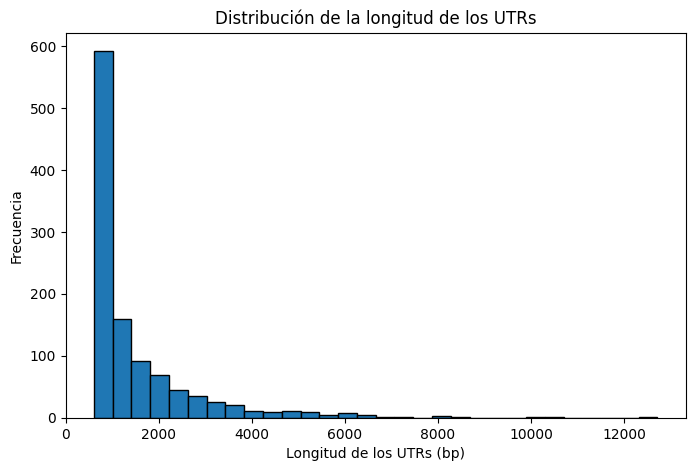

In [ ]:
import matplotlib.pyplot as plt

# Calcular o comprimento de cada UTR
df_utr["length"] = df_utr["end"] - df_utr["start"]

# Plotar um histograma de comprimento
plt.figure(figsize=(8, 5))
plt.hist(df_utr["length"], bins=30, edgecolor='black')
plt.xlabel("Comprimento UTR (bp)")
plt.ylabel("Frequ√™ncia")
plt.title("Distribui√ß√£o do Comprimento UTR")
plt.show()

In [ ]:
#Executar merge_pa
!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
scape merge_pa --output_dir /content/scape/examples/toy-example/ \
--utr_merge True"

In [ ]:
# Verifique se "prepare_input" funcionou
# Espere arquivos ".pk1"
import os

# Listar arquivos gerados
os.listdir("/content/scape/examples/toy-example/pkl_input/")

In [ ]:
# Exibindo par√¢metros por "infer_pa" (res.utr.pkl)
!conda run -n scape_env bash -c \
"unset MPLBACKEND && export MPLBACKEND=Agg && \
python -c 'import pickle; f=open(\"/content/scape/examples/toy-example/res.utr.pkl\", \"rb\"); \
print(pickle.load(f))'"

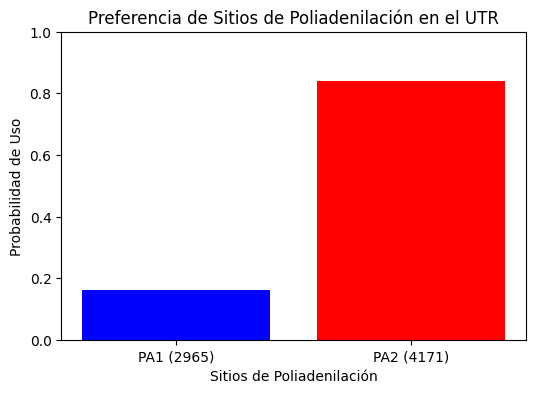

In [ ]:
import matplotlib.pyplot as plt

# Dados do S√≠tio PA
pa_sites = ["PA1 (2965)", "PA2 (4171)"]
usage_probs = [0.16, 0.84]

# Criar Gr√°fico de Barras
plt.figure(figsize=(6, 4))
plt.bar(pa_sites, usage_probs, color=['blue', 'red'])
plt.xlabel("S√≠tios de Poliadenila√ß√£o")
plt.ylabel("Probabilidade de Uso")
plt.title("Prefer√™ncia do S√≠tio de Poliadenila√ß√£o na UTR")
plt.ylim(0, 1)

# Mostrar gr√°fico
plt.show()

In [ ]:
# merge_pa
# Revisar o conte√∫do do arquivo mesclado
with open("/content/scape/examples/toy-example/res.gene.pkl", "rb") as f:
    try:
        merged_pa = pickle.load(f)
        print(merged_pa)
    except EOFError:
        print("O arquivo res.gene.pkl est√° vazio.")

In [ ]:
# cal_exp_pa_len
df_exp_len = pd.read_csv("/content/scape/examples/toy-example/cluster_wrt_CB.gene.pa.len.csv")

# Mostrar primeiras linhas
df_exp_len.head()

gene_id cell_cluster  exp_length  num_pa
0  ENSG00000099194:1        cell1    8.555119       2

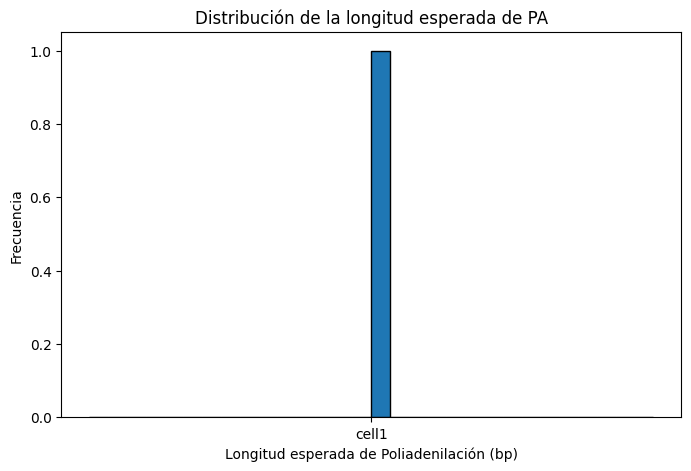

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df_exp_len.iloc[:, 1], bins=30, edgecolor='black')
plt.xlabel("Comprimento Esperado de Poliadenila√ß√£o (pb)")
plt.ylabel("Frequ√™ncia")
plt.title("Distribui√ß√£o do Comprimento Esperado de PA")
plt.show()

In [ ]:
#ex_pa_cnt_mat

df_counts = pd.read_csv("/content/scape/examples/toy-example/res.utr.cnt.tsv.gz", sep="\t")

# Mostrar primeiras linhas
df_counts.head()

pa_info  C1_AAACCTGAGACTCGGA-1  \
0  10:100363599:45.0:+:1:ENSG00000099194:1                    0.0   
1  10:100364805:50.0:+:2:ENSG00000099194:1                    0.0   

   C1_AAACCTGAGAGCCTAG-1  C1_AAACCTGAGCCCGAAA-1  C1_AAACCTGAGTACGCGA-1  \
0                    0.0                    0.0                    0.0   
1                    0.0                    1.0                    0.0   

   C1_AAACCTGAGTGGCACA-1  C1_AAACCTGCAAAGCGGT-1  C1_AAACCTGCACTTGGAT-1  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   

   C1_AAACCTGCATGGGACA-1  C1_AAACCTGGTGTCCTCT-1  ...  S3_TTTGTCAAGTGGAGTC-1  \
0                    0.0                    0.0  ...                    0.0   
1                    0.0                    0.0  ...                    0.0   

   S3_TTTGTCAAGTTCGATC-1  S3_TTTGTCACAGTTAACC-1  S3_TTTGTCACATGTAGTC-1  \
0                    1.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   

   S3_TTTGTCACATTGGTAC-1  S3_TTTGTCAGTCATGCCG-1  S3_TTTGTCAGTCTTTCAT-1  \
0                    0.0                    0.0                    0.0   
1                    0.0                    1.0                    0.0   

   S3_TTTGTCATCCCTAACC-1  S3_TTTGTCATCGATCCCT-1  S3_TTTGTCATCTCCGGTT-1  
0                    0.0                    0.0                    1.0  
1                    0.0                    0.0                    1.0  

[2 rows x 33089 columns]

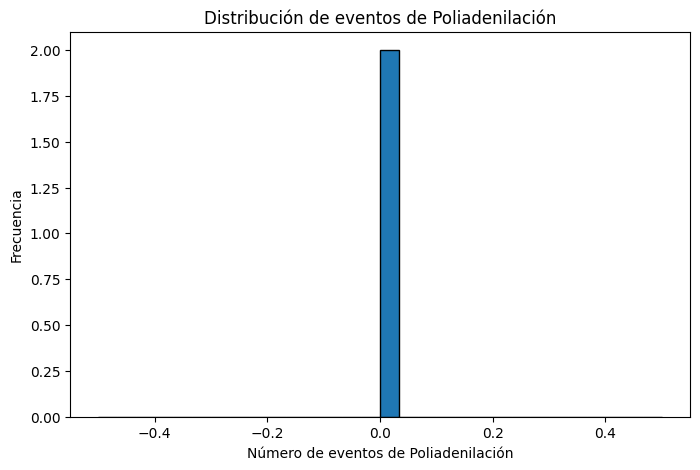

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df_counts.iloc[:, 1], bins=30, edgecolor='black')
plt.xlabel("N√∫mero de Eventos de Poliadenila√ß√£o")
plt.ylabel("Frequ√™ncia")
plt.title("Distribui√ß√£o de Eventos de Poliadenila√ß√£o")
plt.show()